[Успех] Данные загружены
Размерность данных: (8057, 19)

Пример данных:
          cve_id                                       project  \
0  CVE-2016-6307            https://github.com/openssl/openssl   
1            NaN  https://github.com/AFNetworking/AFNetworking   
2  CVE-2017-6797          https://github.com/mantisbt/mantisbt   

                                        sha   dataset   cwe_id  \
0  c1ef7c971d0bbf117c3c80f65b5875e2e7b024b1  SECBENCH  CWE-400   
1  c23c37ab4ab9b2401e824df717538e37bc5c85a4  SECBENCH  CWE-401   
2  c272c3f65da9677e505ff692b1f1e476b3afa56e  SECBENCH   CWE-79   

           vuln_type  score  \
0  Denial Of Service    4.3   
1                NaN    NaN   
2                NaN    4.3   

                                              github  \
0  https://github.com/openssl/openssl/commit/c1ef...   
1  https://github.com/AFNetworking/AFNetworking/c...   
2  https://github.com/mantisbt/mantisbt/commit/c2...   

                                             sum

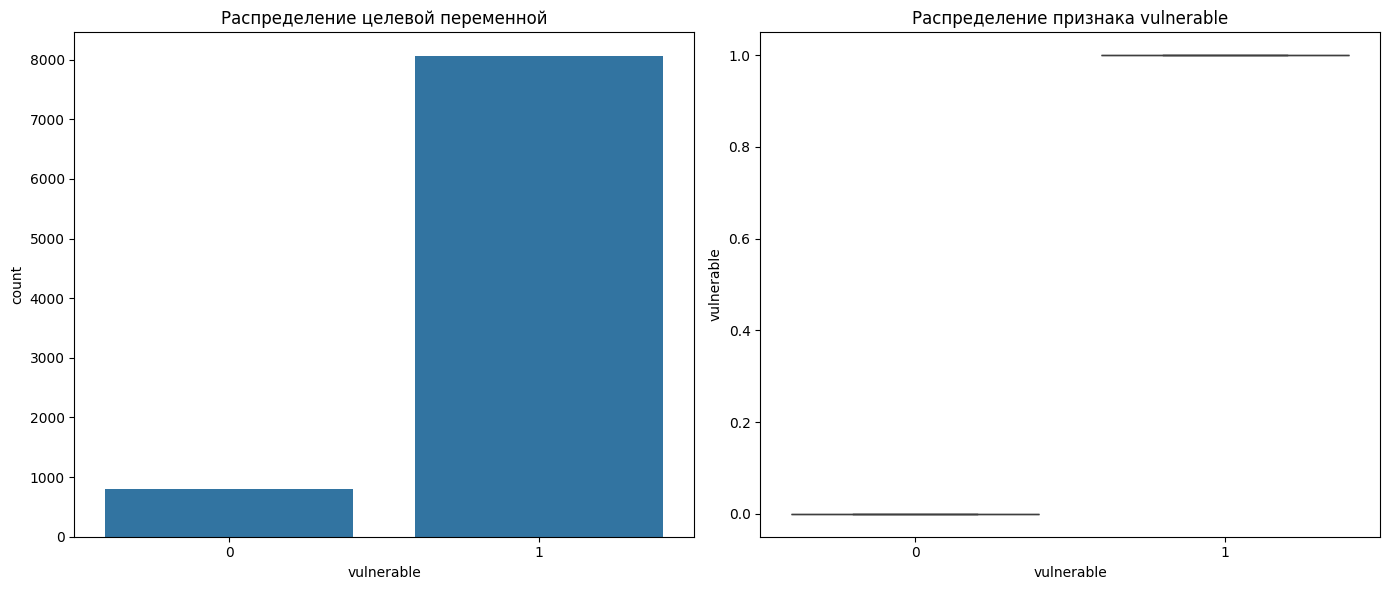


[Действие] Применяем SMOTE для балансировки классов...

[Результаты] Оценка моделей (F1-мера):
Логистическая регрессия: 0.390 (время: 5.7 сек)
Случайный лес: 0.866 (время: 36.4 сек)
Метод опорных векторов: 0.405 (время: 1342.3 сек)

[Обучение] Тренируем модель случайного леса...

[Отчет] Метрики классификации:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2418
           1       0.90      0.94      0.92      2417

    accuracy                           0.92      4835
   macro avg       0.92      0.92      0.92      4835
weighted avg       0.92      0.92      0.92      4835



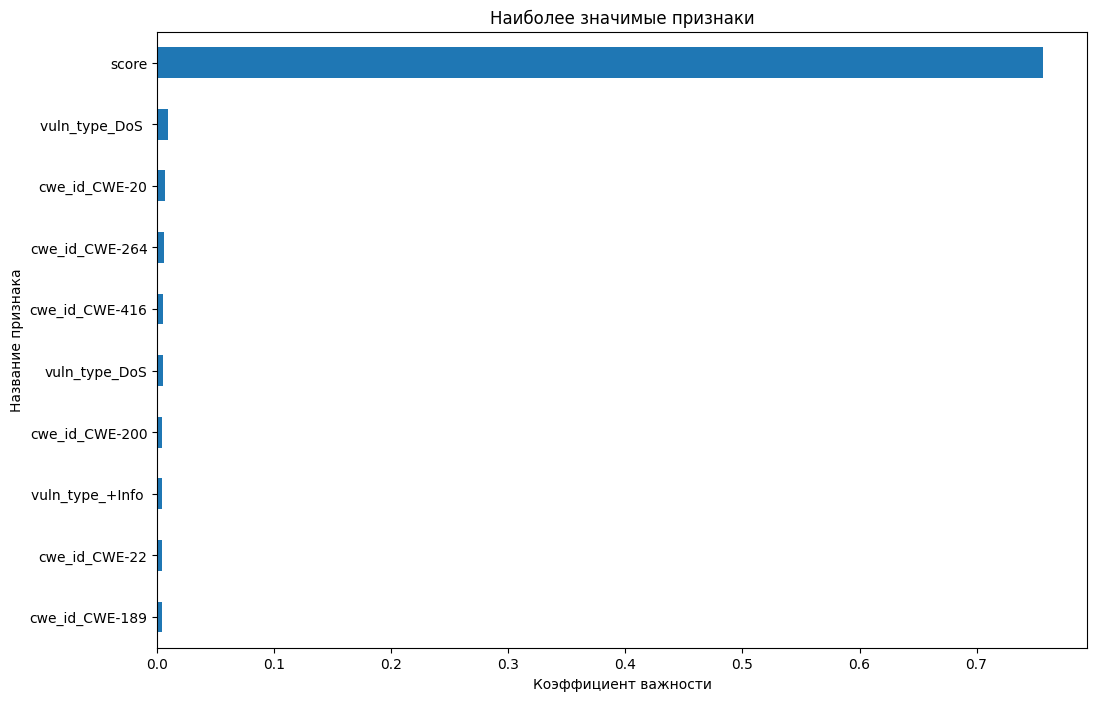

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

##########################################################################
### Загрузка и первичный анализ данных
def load_dataset(file_path):
    """
    Загрузка и проверка данных
    Возвращает DataFrame или завершает программу при ошибке
    """
    try:
        dataset = pd.read_csv(file_path)
        print("[Успех] Данные загружены")
        print(f"Размерность данных: {dataset.shape}")
        print("\nПример данных:")
        print(dataset.head(3))
        return dataset
    except Exception as error:
        print(f"[Ошибка] Проблема при загрузке: {error}")
        exit()

raw_data = load_dataset('security_patches.csv')

##########################################################################
### Предварительная обработка данных
def prepare_features(input_df):
    """
    Подготовка данных для моделирования:
    - Удаление лишних столбцов
    - Кодирование категориальных переменных
    - Обработка пропусков
    - Балансировка классов
    """
    # Удаление неинформативных признаков
    irrelevant_columns = [
        'cve_id', 'sha', 'github', 'summary',
        'message', 'author', 'parents',
        'ext_files', 'files', 'lang',
        'comments', 'dataset', 'date', 'project'
    ]
    cleaned_df = input_df.drop(columns=irrelevant_columns, errors='ignore')

    # Преобразование целевой переменной
    cleaned_df['vulnerable'] = cleaned_df['vulnerable'].map(
        {'yes': 1, 'no': 0}).fillna(0)

    # Генерация синтетических данных при необходимости
    if cleaned_df['vulnerable'].sum() == len(cleaned_df):
        print("\n[Внимание] Обнаружен несбалансированный набор. Создаем синтетические примеры...")
        synthetic_samples = cleaned_df.sample(
            max(1, len(cleaned_df) // 10),
            random_state=42
        ).copy()
        synthetic_samples['vulnerable'] = 0

        # Добавление случайных вариаций
        numeric_features = synthetic_samples.select_dtypes(include=np.number).columns.drop('vulnerable')
        for feature in numeric_features:
            synthetic_samples[feature] *= np.random.uniform(0.8, 1.2, size=len(synthetic_samples))

        cleaned_df = pd.concat([cleaned_df, synthetic_samples], ignore_index=True)

    # Преобразование категориальных переменных
    categorical_features = ['cwe_id', 'language', 'vuln_type']
    cleaned_df = pd.get_dummies(
        cleaned_df,
        columns=categorical_features,
        drop_first=True
    )

    # Заполнение пропущенных значений
    numeric_features = cleaned_df.select_dtypes(include=np.number).columns
    cleaned_df[numeric_features] = cleaned_df[numeric_features].fillna(
        cleaned_df[numeric_features].median())

    return cleaned_df

processed_data = prepare_features(raw_data)
print("\n[Информация] Признаковое пространство после обработки:")
print(f"Общее количество признаков: {len(processed_data.columns)}")
print("Список признаков:", list(processed_data.columns))

##########################################################################
### Визуализация данных
def plot_data_distribution(data_frame):
    """Графический анализ распределения данных"""
    plt.figure(figsize=(14, 6))

    # Распределение классов
    plt.subplot(1, 2, 1)
    sns.countplot(x='vulnerable', data=data_frame)
    plt.title('Распределение целевой переменной')

    # Распределение числового признака
    plt.subplot(1, 2, 2)
    numeric_feature = data_frame.select_dtypes(include=np.number).columns[1]
    sns.boxplot(x='vulnerable', y=numeric_feature, data=data_frame)
    plt.title(f'Распределение признака {numeric_feature}')

    plt.tight_layout()
    plt.show()

plot_data_distribution(processed_data)

##########################################################################
### Подготовка к моделированию
# Разделение на признаки и целевую переменную
features = processed_data.drop('vulnerable', axis=1)
target = processed_data['vulnerable']

# Балансировка классов
if target.mean() > 0.7:
    print("\n[Действие] Применяем SMOTE для балансировки классов...")
    features, target = SMOTE(random_state=42).fit_resample(features, target)

# Нормализация данных
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    normalized_features,
    target,
    test_size=0.3,
    stratify=target,
    random_state=42
)

##########################################################################
### Моделирование и оценка
# Инициализация моделей
ml_models = {
    'Логистическая регрессия': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'Случайный лес': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=150,
        random_state=42
    ),
    'Метод опорных векторов': SVC(
        class_weight='balanced',
        probability=True,
        kernel='rbf',
        random_state=42
    )
}

# Кросс-валидация
print("\n[Результаты] Оценка моделей (F1-мера):")
for model_name, model in ml_models.items():
    start_time = time()
    cv_scores = cross_val_score(
        model,
        normalized_features,
        target,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    print(f"{model_name}: {np.mean(cv_scores):.3f} (время: {time()-start_time:.1f} сек)")

# Обучение лучшей модели
print("\n[Обучение] Тренируем модель случайного леса...")
final_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train, y_train)

# Оценка качества
predictions = final_model.predict(X_test)
print("\n[Отчет] Метрики классификации:")
print(classification_report(y_test, predictions))

##########################################################################
### Анализ важности признаков
def plot_feature_importance(model, feature_names):
    """Визуализация важности признаков"""
    importance_values = pd.Series(
        model.feature_importances_,
        index=feature_names
    )

    plt.figure(figsize=(12, 8))
    importance_values.nlargest(10).sort_values().plot(kind='barh')
    plt.title('Наиболее значимые признаки')
    plt.xlabel('Коэффициент важности')
    plt.ylabel('Название признака')
    plt.show()

plot_feature_importance(
    final_model,
    processed_data.drop('vulnerable', axis=1).columns
)